## Data Preprocessing and Merging

In [ ]:
# Import necessary libraries
import pandas as pd
import os
import glob

# Define the directory containing weather data files
weather_dir = "weather_data"

# Get a list of all CSV files in the weather_data directory
csv_files = glob.glob(os.path.join(weather_dir, "*.csv"))
print(f"Found {len(csv_files)} CSV files in {weather_dir} directory")

# Create an empty list to store dataframes
dfs = []

# Process each CSV file
for file in csv_files:
    # Extract city name from filename
    city_name = os.path.basename(file).replace('.csv', '')
    
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Add a city column
    df['city'] = city_name
    
    # Append to the list
    dfs.append(df)
    
    print(f"Processed {city_name} with {len(df)} rows")

# Combine all dataframes
combined_df = pd.concat(dfs, ignore_index=True)
print(f"Combined dataframe shape: {combined_df.shape}")

# Convert date column to datetime
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Save the combined dataframe to a new CSV file
combined_df.to_csv("combined_weather_data.csv", index=False)
print("Saved combined weather data to 'combined_weather_data.csv'")

Found 13 CSV files in weather_data directory
Processed Bhopal with 123936 rows
Processed Durgapur with 123936 rows
Processed Ghaziabad with 123936 rows
Processed Gurgaon with 123936 rows
Processed Hubli with 123936 rows
Processed Jaipur with 123936 rows
Processed Jammu with 123936 rows
Processed Kochi with 123936 rows
Processed Lucknow with 123936 rows
Processed Madurai with 123936 rows
Processed New Delhi with 123936 rows
Processed Patna with 123936 rows
Processed Pune with 123936 rows
Combined dataframe shape: (1611168, 22)
Saved combined weather data to 'combined_weather_data.csv'


In [3]:
# Import pandas
import pandas as pd

# Read the combined weather data file
df = pd.read_csv("combined_weather_data.csv")

# Drop the unnamed column
df = df.drop(columns=["Unnamed: 0"])

# Save back to the same file
df.to_csv("combined_weather_data.csv", index=False)

print("Removed 'Unnamed: 0' column from combined_weather_data.csv")

Removed 'Unnamed: 0' column from combined_weather_data.csv


In [4]:
# Import pandas
import pandas as pd

# Read the combined weather data file
df = pd.read_csv("combined_weather_data.csv")

# Convert date to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'])

# Extract just the date part (removing time) and format it to YYYY-MM-DD
df['date'] = df['date'].dt.date

# Create a new column for merging later
# This will be the column that matches with the Book1.csv dates
df['merge_date'] = df['date']

# Save back to the same file
df.to_csv("combined_weather_data.csv", index=False)

print("Standardized dates in combined_weather_data.csv")

Standardized dates in combined_weather_data.csv


In [6]:
# Import pandas
import pandas as pd

# Read the Book1.csv file
book1_df = pd.read_csv("Book1.csv")

# Display original format
print("Original 'Invoice Date' format:")
print(book1_df['Invoice Date'].head())

# Convert 'Invoice Date' to datetime
book1_df['Invoice Date'] = pd.to_datetime(book1_df['Invoice Date'], format="%m/%d/%Y")

# Create a standardized date column for merging
book1_df['merge_date'] = book1_df['Invoice Date'].dt.date

# Verify the conversion
print("\nAfter conversion:")
print(book1_df[['Invoice Date', 'merge_date']].head())

# Save the modified dataframe back to the original file
book1_df.to_csv("Book1.csv", index=False)

print("\nSaved standardized dates to Book1.csv")

Original 'Invoice Date' format:
0    4/5/2024
1    4/5/2024
2    4/5/2024
3    4/5/2024
4    4/6/2024
Name: Invoice Date, dtype: object

After conversion:
  Invoice Date  merge_date
0   2024-04-05  2024-04-05
1   2024-04-05  2024-04-05
2   2024-04-05  2024-04-05
3   2024-04-05  2024-04-05
4   2024-04-06  2024-04-06

Saved standardized dates to Book1.csv


In [7]:
# Import pandas
import pandas as pd
import numpy as np

# Define city mapping
city_mapping = {
    "BHP": "Bhopal", "DGP": "Durgapur", "DLI": "New_Delhi", "GRN": "Gurgaon",
    "GZB": "Ghaziabad", "HBI": "Hubli", "JMU": "Jammu", "JPR": "Jaipur",
    "KCI": "Kochi", "LKW": "Lucknow", "MDI": "Madurai", "PNE": "Pune",
    "PTA": "Patna"
}

# Load the datasets
weather_df = pd.read_csv("combined_weather_data.csv")
invoice_df = pd.read_csv("Book1.csv")

# Ensure date formats are consistent
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['merge_date'] = weather_df['date'].dt.date

invoice_df['Invoice Date'] = pd.to_datetime(invoice_df['Invoice Date'])
invoice_df['merge_date'] = invoice_df['Invoice Date'].dt.date

# Add full city name column to invoice data
invoice_df['city'] = invoice_df['Sales Location'].map(city_mapping)

# Aggregate weather data to daily values (important since weather data is likely hourly)
weather_daily = weather_df.groupby(['merge_date', 'city']).agg({
    'temperature_2m': 'mean',
    'relative_humidity_2m': 'mean',
    'dew_point_2m': 'mean',
    'apparent_temperature': 'mean',
    'precipitation': 'sum',  # Sum precipitation for the day
    'rain': 'sum',
    'pressure_msl': 'mean',
    'wind_speed_10m': 'mean',
    'wind_gusts_10m': 'max'  # Maximum wind gusts for the day
}).reset_index()

print(f"Weather daily aggregated shape: {weather_daily.shape}")
print(f"Invoice data shape: {invoice_df.shape}")

# Merge datasets on date and city
merged_df = pd.merge(
    invoice_df,
    weather_daily,
    how='left',
    left_on=['merge_date', 'city'],
    right_on=['merge_date', 'city']
)

print(f"Merged data shape: {merged_df.shape}")

# Check for any null values that might indicate merge issues
null_counts = merged_df.isnull().sum()
print("\nNull counts in merged dataframe:")
print(null_counts[null_counts > 0])  # Only show columns with nulls

# Check how many invoice rows have matching weather data
has_weather = merged_df['temperature_2m'].notna().sum()
print(f"\nInvoice rows with matching weather data: {has_weather} out of {len(merged_df)} ({has_weather/len(merged_df)*100:.2f}%)")

# Save the merged dataframe
merged_df.to_csv("merged_invoice_weather.csv", index=False)

print("\nSaved merged data to merged_invoice_weather.csv")

Weather daily aggregated shape: (67132, 11)
Invoice data shape: (18004, 10)
Merged data shape: (18004, 19)

Null counts in merged dataframe:
temperature_2m          5226
relative_humidity_2m    5226
dew_point_2m            5226
apparent_temperature    5226
precipitation           5226
rain                    5226
pressure_msl            5226
wind_speed_10m          5226
wind_gusts_10m          5226
dtype: int64

Invoice rows with matching weather data: 12778 out of 18004 (70.97%)

Saved merged data to merged_invoice_weather.csv


In [8]:
# Import pandas
import pandas as pd

# Load the merged dataset
merged_df = pd.read_csv("merged_invoice_weather.csv")

# Display the original row count
print(f"Original row count: {len(merged_df)}")

# Drop rows where weather data is null
# Using temperature_2m as the indicator column for weather data
cleaned_df = merged_df.dropna(subset=['temperature_2m'])

# Display the new row count
print(f"Row count after removing nulls: {len(cleaned_df)}")
print(f"Removed {len(merged_df) - len(cleaned_df)} rows")

# Save the cleaned dataframe back to the same file
cleaned_df.to_csv("merged_invoice_weather.csv", index=False)

print("\nSaved cleaned data to merged_invoice_weather.csv")

Original row count: 18004
Row count after removing nulls: 12778
Removed 5226 rows

Saved cleaned data to merged_invoice_weather.csv


## PCA Starts Here

Dataset shape: (13975, 19)

Columns:
['Invoice Date', 'Capacity Rating', 'Energy Rating', 'Invoice Quantity', 'Sales Zone', 'Sales Location', 'Sales Channel', 'Sales Margin', 'merge_date', 'city', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'pressure_msl', 'wind_speed_10m', 'wind_gusts_10m']

Data types:
Invoice Date             object
Capacity Rating         float64
Energy Rating             int64
Invoice Quantity          int64
Sales Zone               object
Sales Location           object
Sales Channel            object
Sales Margin             object
merge_date               object
city                     object
temperature_2m          float64
relative_humidity_2m    float64
dew_point_2m            float64
apparent_temperature    float64
precipitation           float64
rain                    float64
pressure_msl            float64
wind_speed_10m          float64
wind_gusts_10m          float64
dtype: object

Numerica

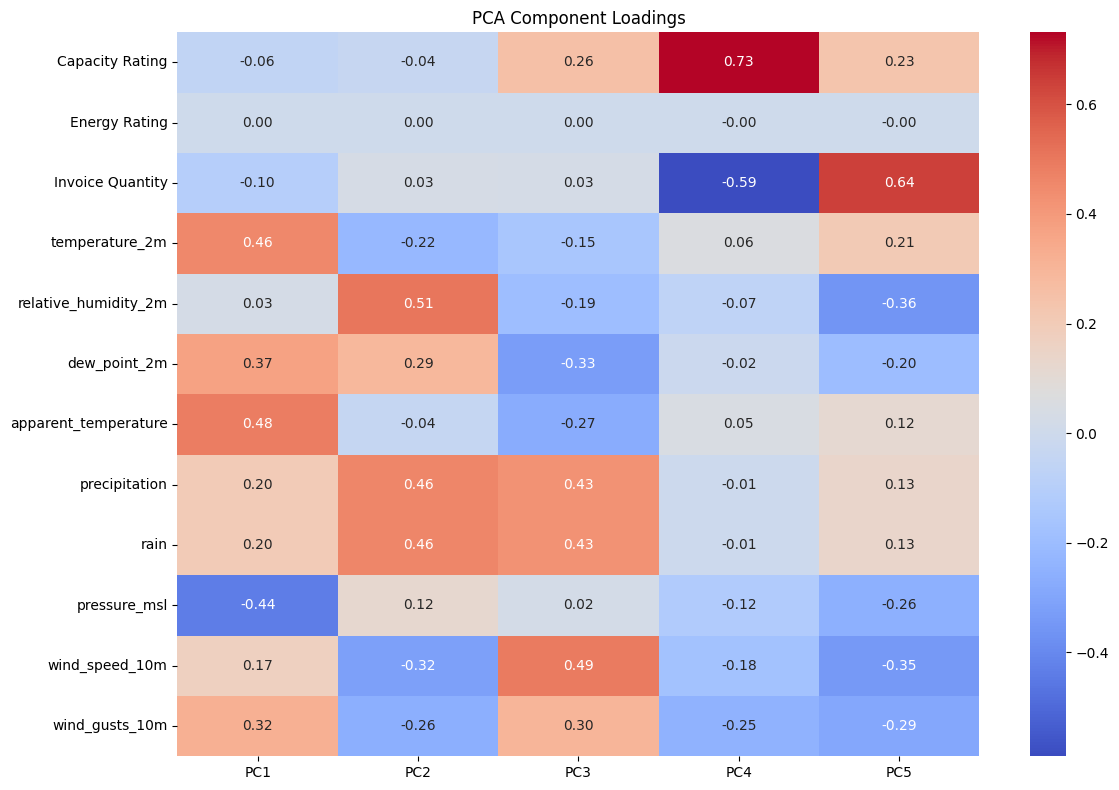

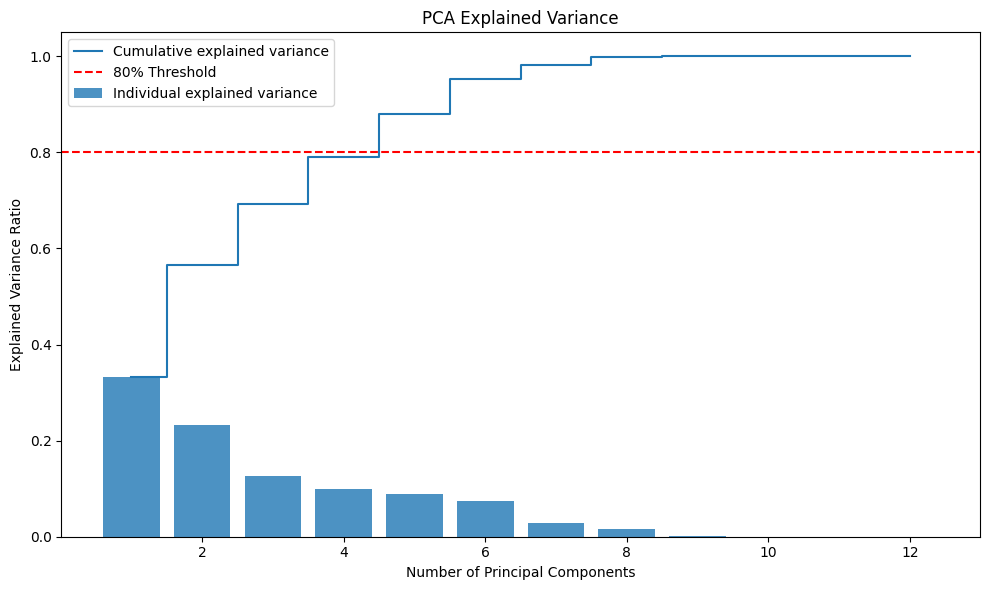

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned merged dataset
df = pd.read_csv("merged_invoice_weather.csv")

# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())

# Select only numerical columns for PCA, excluding dates, categories, and IDs
# First, let's check datatypes
print("\nData types:")
print(df.dtypes)

# Identify numerical columns (excluding dates and categorical variables)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove any merge/date/id columns from numerical columns if they exist
columns_to_exclude = ['merge_date', 'Invoice Date']
numerical_cols = [col for col in numerical_cols if col not in columns_to_exclude]

print(f"\nNumerical columns for PCA: {numerical_cols}")
print(f"Number of features: {len(numerical_cols)}")

# Extract the features for PCA
X = df[numerical_cols].copy()

# Check for any remaining missing values
print("\nMissing values in numerical columns:")
print(X.isnull().sum())

# Fill any remaining missing values with column means
X = X.fillna(X.mean())

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratios
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print variance explained by each component
print("\nVariance explained by each component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

# Determine number of components needed to explain 80% of variance
n_components_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
print(f"\nNumber of components needed to explain 80% of variance: {n_components_80}")

# Create a DataFrame with component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=numerical_cols
)

# Print the top features for the first few PCs
n_top = 5  # Number of top features to show
print("\nTop feature loadings for first 3 principal components:")
for i in range(3):  # Show first 3 PCs
    pc = f'PC{i+1}'
    print(f"\n{pc} (explains {explained_variance[i]:.4f} of variance)")
    print(loadings[pc].abs().sort_values(ascending=False).head(n_top))

# Create a heatmap of the first few components' loadings
plt.figure(figsize=(12, 8))
sns.heatmap(
    loadings.iloc[:, :5],  # First 5 components
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title('PCA Component Loadings')
plt.tight_layout()
plt.savefig('pca_loadings.png')

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(
    range(1, len(explained_variance) + 1),
    explained_variance,
    alpha=0.8,
    label='Individual explained variance'
)
plt.step(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where='mid',
    label='Cumulative explained variance'
)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('pca_explained_variance.png')

print("\nPCA analysis complete. Visualizations saved as 'pca_loadings.png' and 'pca_explained_variance.png'")

## Making the data sequential

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle

# Load the merged dataset
df = pd.read_csv("merged_invoice_weather.csv")

# Make sure date columns are in datetime format
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
df['merge_date'] = pd.to_datetime(df['merge_date'])

# Group by city and day first
daily_data = df.groupby(['city', pd.Grouper(key='merge_date', freq='D')]).agg({
    'Invoice Quantity': 'sum',
    'temperature_2m': 'mean',
    'relative_humidity_2m': 'mean',
    'dew_point_2m': 'mean',
    'apparent_temperature': 'mean',
    'precipitation': 'mean',
    'rain': 'mean',
    'pressure_msl': 'mean',
    'wind_speed_10m': 'mean',
    'wind_gusts_10m': 'mean'
}).reset_index()

# Now correctly resample to weekly frequency
# For each city, resample the daily data to weekly
weekly_data_list = []

for city in daily_data['city'].unique():
    # Filter data for this city
    city_data = daily_data[daily_data['city'] == city].copy()
    
    # Set date as index for resampling
    city_data.set_index('merge_date', inplace=True)
    
    # Resample to weekly frequency
    weekly_city_data = city_data.resample('M').agg({
        'city': 'first',  # Keep the city name
        'Invoice Quantity': 'sum',
        'temperature_2m': 'mean',
        'relative_humidity_2m': 'mean',
        'dew_point_2m': 'mean',
        'apparent_temperature': 'mean',
        'precipitation': 'mean',
        'rain': 'mean', 
        'pressure_msl': 'mean',
        'wind_speed_10m': 'mean',
        'wind_gusts_10m': 'mean'
    })
    
    # Reset index to make merge_date a column again
    weekly_city_data.reset_index(inplace=True)
    
    # Add to our list
    weekly_data_list.append(weekly_city_data)

# Combine all city data
weekly_data = pd.concat(weekly_data_list)

print(f"Weekly resampled data shape: {weekly_data.shape}")
print(weekly_data.head())

# Sort data chronologically
weekly_data = weekly_data.sort_values(['city', 'merge_date'])

# Create a list of features (all numerical columns except the target)
features = [col for col in weekly_data.columns if col not in ['city', 'merge_date', 'Invoice Quantity']]
print(f"\nFeatures: {features}")

# Define a function to create lagged sequences
def create_sequences(data, cities, seq_length=4, target_col='Invoice Quantity'):
    X, y = [], []
    
    # Process each city separately to avoid sequence breaks
    for city in cities:
        city_data = data[data['city'] == city].copy()
        
        # Skip if we don't have enough data points for this city
        if len(city_data) <= seq_length:
            continue
        
        # Get the already scaled values
        scaled_features = city_data[features].values
        scaled_target = city_data[target_col].values
        
        # Create sequences
        for i in range(len(city_data) - seq_length):
            # Extract sequence (all features)
            X.append(scaled_features[i:i+seq_length])
            # Extract target (next week's invoice quantity)
            y.append(scaled_target[i+seq_length])
    
    return np.array(X), np.array(y)

# Get unique cities
cities = weekly_data['city'].unique()
print(f"\nNumber of unique cities: {len(cities)}")

# Chronological split - 80% train, 20% test
# First, determine the cutoff date
sorted_dates = sorted(weekly_data['merge_date'].unique())
split_idx = int(len(sorted_dates) * 0.8)
split_date = sorted_dates[split_idx]
print(f"\nSplit date: {split_date}")

# Split data
train_data = weekly_data[weekly_data['merge_date'] < split_date]
test_data = weekly_data[weekly_data['merge_date'] >= split_date]

print(f"\nTraining data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Scale features (fit only on training data)
scaler = MinMaxScaler()
train_cities = train_data['city'].unique()
test_cities = test_data['city'].unique()

# Scale all features including the target
all_cols = features + ['Invoice Quantity']
scaler.fit(train_data[all_cols])

# Apply scaling to both train and test sets
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

train_data_scaled[all_cols] = scaler.transform(train_data[all_cols])
test_data_scaled[all_cols] = scaler.transform(test_data[all_cols])

# Create sequences
seq_length = 4  # 4 weeks of history
X_train, y_train = create_sequences(train_data_scaled, train_cities, seq_length)
X_test, y_test = create_sequences(test_data_scaled, test_cities, seq_length)

print(f"\nX_train shape: {X_train.shape}")  # [samples, time steps, features]
print(f"y_train shape: {y_train.shape}")    # [samples]
print(f"X_test shape: {X_test.shape}")      # [samples, time steps, features]
print(f"y_test shape: {y_test.shape}")      # [samples]

# Save the preprocessed data for later use
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

print("\nSequence data has been created and saved to disk")
print("Format: [samples, time steps, features]")
print(f"Features: {len(features)}")
print(f"Time steps (lag): {seq_length}")

# Save the scaler for later use
with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nMinMaxScaler has been saved to 'minmax_scaler.pkl'")

Weekly resampled data shape: (1775, 12)
  merge_date      city  Invoice Quantity  temperature_2m  \
0 2021-04-18  Durgapur                 5       29.441333   
1 2021-04-25  Durgapur                 1       30.826750   
2 2021-05-02      None                 0             NaN   
3 2021-05-09      None                 0             NaN   
4 2021-05-16      None                 0             NaN   

   relative_humidity_2m  dew_point_2m  apparent_temperature  precipitation  \
0             52.135600     17.439250             31.178905            0.0   
1             62.842079     21.674666             34.635939            0.0   
2                   NaN           NaN                   NaN            NaN   
3                   NaN           NaN                   NaN            NaN   
4                   NaN           NaN                   NaN            NaN   

   rain  pressure_msl  wind_speed_10m  wind_gusts_10m  
0   0.0   1010.220833        8.689090       35.640000  
1   0.0   1006.733

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pickle

# Load the merged dataset
df = pd.read_csv("merged_invoice_weather.csv")

# Make sure date columns are in datetime format
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
df['merge_date'] = pd.to_datetime(df['merge_date'])

# Group by city and day first
daily_data = df.groupby(['city', pd.Grouper(key='merge_date', freq='D')]).agg({
    'Invoice Quantity': 'sum',
    'temperature_2m': 'mean',
    'relative_humidity_2m': 'mean',
    'dew_point_2m': 'mean',
    'apparent_temperature': 'mean',
    'precipitation': 'mean',
    'rain': 'mean',
    'pressure_msl': 'mean',
    'wind_speed_10m': 'mean',
    'wind_gusts_10m': 'mean'
}).reset_index()

# Now correctly resample to weekly frequency
# For each city, resample the daily data to weekly
weekly_data_list = []

for city in daily_data['city'].unique():
    # Filter data for this city
    city_data = daily_data[daily_data['city'] == city].copy()
    
    # Set date as index for resampling
    city_data.set_index('merge_date', inplace=True)
    
    # Resample to weekly frequency
    weekly_city_data = city_data.resample('W').agg({
        'city': 'first',  # Keep the city name
        'Invoice Quantity': 'sum',
        'temperature_2m': 'mean',
        'relative_humidity_2m': 'mean',
        'dew_point_2m': 'mean',
        'apparent_temperature': 'mean',
        'precipitation': 'mean',
        'rain': 'mean', 
        'pressure_msl': 'mean',
        'wind_speed_10m': 'mean',
        'wind_gusts_10m': 'mean'
    })
    
    # Reset index to make merge_date a column again
    weekly_city_data.reset_index(inplace=True)
    
    # Add to our list
    weekly_data_list.append(weekly_city_data)

# Combine all city data
weekly_data = pd.concat(weekly_data_list)

print(f"Weekly resampled data shape: {weekly_data.shape}")
print(weekly_data.head())

# Sort data chronologically
weekly_data = weekly_data.sort_values(['city', 'merge_date'])

# Create a list of features (all numerical columns except the target)
features = [col for col in weekly_data.columns if col not in ['city', 'merge_date', 'Invoice Quantity']]
print(f"\nFeatures: {features}")

# Define a function to create lagged sequences
def create_sequences(data, cities, seq_length=4, target_col='Invoice Quantity'):
    X, y = [], []
    city_indices = []  # To track which city each sequence belongs to
    
    # Process each city separately to avoid sequence breaks
    for city in cities:
        city_data = data[data['city'] == city].copy().sort_values('merge_date')  # Explicit sorting
        
        # Skip if we don't have enough data points for this city
        if len(city_data) <= seq_length:
            print(f"Warning: Not enough data points for {city}. Skipping.")
            continue
        
        # Get the scaled values
        scaled_features = city_data[features].values
        scaled_target = city_data[target_col].values
        
        # Create sequences
        for i in range(len(city_data) - seq_length):
            # Extract sequence (all features)
            X.append(scaled_features[i:i+seq_length])
            # Extract target (next week's invoice quantity)
            y.append(scaled_target[i+seq_length])
            # Track city
            city_indices.append(city)
    
    return np.array(X), np.array(y), city_indices

# Get unique cities
cities = weekly_data['city'].unique()
print(f"\nNumber of unique cities: {len(cities)}")
print(f"Cities: {cities}")

# Chronological split - 80% train, 20% test
# First, determine the cutoff date
sorted_dates = sorted(weekly_data['merge_date'].unique())
split_idx = int(len(sorted_dates) * 0.8)
split_date = sorted_dates[split_idx]
print(f"\nSplit date: {split_date}")

# Split data
train_data = weekly_data[weekly_data['merge_date'] < split_date]
test_data = weekly_data[weekly_data['merge_date'] >= split_date]

print(f"\nTraining data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Get cities in each set
train_cities = train_data['city'].unique()
test_cities = test_data['city'].unique()

# Check if all test cities exist in training data
missing_cities = set(test_cities) - set(train_cities)
if missing_cities:
    print(f"Warning: These cities are in test but not in training: {missing_cities}")

# Separate scalers for features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit scalers on training data only
feature_scaler.fit(train_data[features])
target_scaler.fit(train_data[['Invoice Quantity']])

# Apply scaling to both train and test sets
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

# Transform features
train_data_scaled[features] = feature_scaler.transform(train_data[features])
test_data_scaled[features] = feature_scaler.transform(test_data[features])

# Transform target
train_data_scaled['Invoice Quantity'] = target_scaler.transform(train_data[['Invoice Quantity']])
test_data_scaled['Invoice Quantity'] = target_scaler.transform(test_data[['Invoice Quantity']])

# Create sequences
seq_length = 4  # 4 weeks of history
X_train, y_train, train_city_indices = create_sequences(train_data_scaled, train_cities, seq_length)
X_test, y_test, test_city_indices = create_sequences(test_data_scaled, test_cities, seq_length)

print(f"\nX_train shape: {X_train.shape}")  # [samples, time steps, features]
print(f"y_train shape: {y_train.shape}")    # [samples]
print(f"X_test shape: {X_test.shape}")      # [samples, time steps, features]
print(f"y_test shape: {y_test.shape}")      # [samples]

# Save the preprocessed data for later use
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

# Save city indices
with open('train_city_indices.pkl', 'wb') as f:
    pickle.dump(train_city_indices, f)
with open('test_city_indices.pkl', 'wb') as f:
    pickle.dump(test_city_indices, f)

print("\nSequence data has been created and saved to disk")
print("Format: [samples, time steps, features]")
print(f"Features: {len(features)}")
print(f"Time steps (lag): {seq_length}")

# Save the scalers for later use
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)
with open('target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

# Save feature names for reference
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(features, f)

# Save city information
city_info = {
    'train_cities': list(train_cities),
    'test_cities': list(test_cities),
    'all_cities': list(cities)
}
with open('city_info.pkl', 'wb') as f:
    pickle.dump(city_info, f)

print("\nScalers have been saved:")
print("- feature_scaler.pkl: for transforming input features")
print("- target_scaler.pkl: for transforming and inverse transforming the target")
print("\nAdditional metadata saved:")
print("- feature_names.pkl: Names of features in the order they appear in the data")
print("- city_info.pkl: Information about cities in train and test sets")
print("- train_city_indices.pkl & test_city_indices.pkl: City for each sequence")

# Example of how to use the inverse transform for predictions
print("\nExample: How to convert scaled predictions back to original units")
print("y_pred_scaled = model.predict(X_test)")
print("with open('target_scaler.pkl', 'rb') as f:")
print("    target_scaler = pickle.load(f)")
print("y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()")


Weekly resampled data shape: (1637, 12)
  merge_date      city  Invoice Quantity  temperature_2m  \
0 2021-04-18  Durgapur                 5       29.441333   
1 2021-04-25  Durgapur                 1       30.826750   
2 2021-05-02      None                 0             NaN   
3 2021-05-09      None                 0             NaN   
4 2021-05-16      None                 0             NaN   

   relative_humidity_2m  dew_point_2m  apparent_temperature  precipitation  \
0             52.135600     17.439250             31.178905            0.0   
1             62.842079     21.674666             34.635939            0.0   
2                   NaN           NaN                   NaN            NaN   
3                   NaN           NaN                   NaN            NaN   
4                   NaN           NaN                   NaN            NaN   

   rain  pressure_msl  wind_speed_10m  wind_gusts_10m  
0   0.0   1010.220833        8.689090       35.640000  
1   0.0   1006.733